# IFRC Events Analysis by Country

This notebook fetches and visualizes emergency events data from the IFRC GO API for selected countries.

## 1. Import Required Libraries

In [1]:
import os
import requests
from collections import defaultdict
import matplotlib.pyplot as plt
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()
print('Environment variables loaded successfully!')

Environment variables loaded successfully!


## 2. Define Functions

### 2.1 Extract Country ISO3 Codes from API Response

In [2]:
def extract_country_codes(response_results):
    """
    Extract ISO3 country codes from the API response results.
    
    Args:
        response_results: List of event dictionaries from the API
    
    Returns:
        List of ISO3 country codes
    """
    iso3_codes = []
    for result in response_results:
        countries_data = result.get("countries", [])
        for country in countries_data:
            iso3 = country.get("iso3")
            if iso3:
                iso3_codes.append(iso3)
    return iso3_codes

### 2.2 Fetch Events from GO API

In [3]:
def call_go_api(country_ids="123,84,85,27"):
    """
    Fetch emergency events from the IFRC GO API for specified countries.
    
    Args:
        country_ids: Comma-separated string of country IDs to filter by
                    Default: "123,84,85,27" (Nepal, India, Indonesia, Bangladesh)
    
    Returns:
        defaultdict with country ISO3 codes as keys and event counts as values
    """
    go_api_url = "https://goadmin.ifrc.org/api/v2/event/"
    event_counts = defaultdict(int)
    offset = 0
    page_size = 50
    
    # Load token from environment variable
    auth_token = os.getenv('IFRC_API_TOKEN')
    
    if not auth_token:
        raise ValueError('IFRC_API_TOKEN not found in environment. Please check your .env file.')
    
    headers = {"Authorization": f"Token {auth_token}"}

    while True:
        params = {
            "countries__in": country_ids,
            "format": "json",
            "limit": page_size,
            "offset": offset,
        }
        
        response = requests.get(go_api_url, params=params, headers=headers)
        
        # Check for successful response
        if response.status_code != 200:
            print(f"Error: API returned status code {response.status_code}")
            print(f"Response: {response.text}")
            break
        
        go_api_response = response.json()
        results = go_api_response.get("results", [])
        
        # Extract and count country codes
        country_codes = extract_country_codes(results)
        for country_iso3 in country_codes:
            event_counts[country_iso3] += 1

        # Check if there are more pages
        if go_api_response.get("next") is not None:
            offset += page_size
        else:
            break

    return event_counts

### 2.3 Create Bar Chart

In [4]:
def create_events_chart(event_counts, top_n=4, save_path=None):
    """
    Create a bar chart showing event counts by country.
    
    Args:
        event_counts: Dictionary with country ISO3 codes as keys and counts as values
        top_n: Number of top countries to display (default: 4)
        save_path: Optional path to save the chart image
    """
    if not event_counts:
        print("No data to display.")
        return
    
    # Sort by event count in descending order
    sorted_event_counts = dict(
        sorted(event_counts.items(), key=lambda item: item[1], reverse=True)
    )

    # Select top countries
    top_countries = list(sorted_event_counts.keys())[:top_n]
    top_event_counts = list(sorted_event_counts.values())[:top_n]

    # Define custom colors
    custom_colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b"]
    colors = custom_colors[:len(top_countries)]

    # Create the bar chart
    plt.figure(figsize=(9, 7))
    bars = plt.bar(top_countries, top_event_counts, color=colors, zorder=2)

    # Display data labels on the bars
    for bar, label in zip(bars, top_event_counts):
        plt.text(
            bar.get_x() + bar.get_width() / 2,  # Fixed: center the label properly
            bar.get_height() + 0.5,
            str(label),
            ha="center",
            va="bottom",
            fontsize=11,
            fontweight="bold"
        )

    plt.xlabel("Countries (ISO3 Code)", fontsize=12)
    plt.ylabel("Number of Events", fontsize=12)
    plt.title("Number of Emergency Events by Country", fontsize=14, fontweight="bold")
    plt.xticks(rotation=0, fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True, axis="y", linestyle="dotted", alpha=0.5, color="black", zorder=1)
    
    plt.tight_layout()
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Chart saved to: {save_path}")
    
    plt.show()  # Fixed: added plt.show() to display in notebook

## 3. Fetch Data from API

In [5]:
# Fetch event counts from the GO API
# Country IDs: 123=Nepal, 84=India, 85=Indonesia, 27=Bangladesh
event_counts = call_go_api()

print("Event counts by country:")
for country, count in sorted(event_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"  {country}: {count} events")

print(f"\nTotal events across all countries: {sum(event_counts.values())}")

Event counts by country:
  BGD: 124 events
  IND: 111 events
  IDN: 106 events
  NPL: 79 events
  PAK: 2 events
  LKA: 2 events
  MYS: 2 events
  BTN: 1 events
  CHN: 1 events
  MMR: 1 events
  THA: 1 events

Total events across all countries: 430


## 4. Visualize the Data

Chart saved to: events_by_country.png


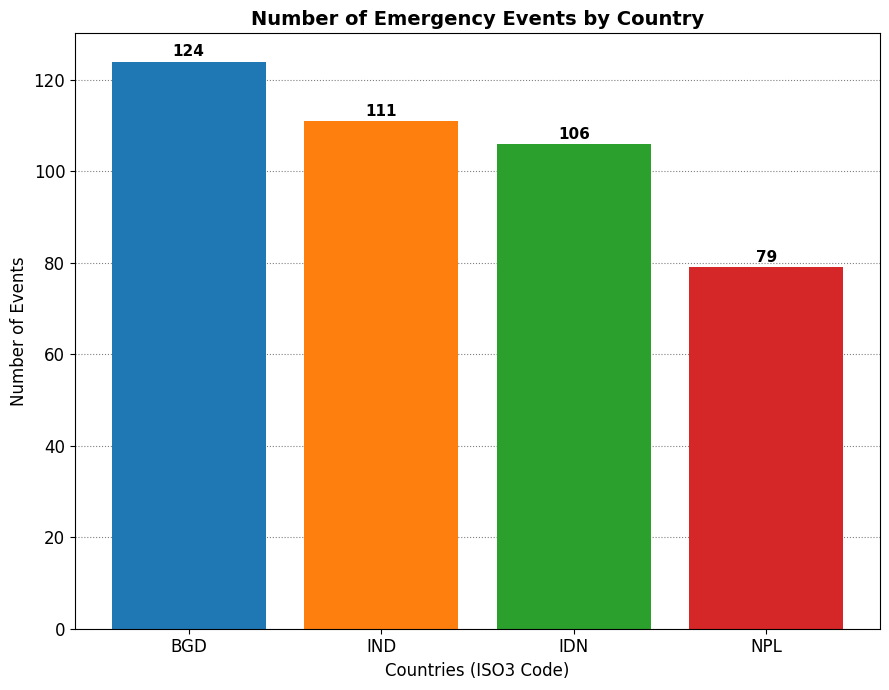

In [6]:
# Create the bar chart (displays in notebook and optionally saves to file)
create_events_chart(event_counts, top_n=4, save_path="events_by_country.png")

## 5. Summary

This notebook:
1. Fetches emergency event data from the IFRC GO API for selected Asian countries
2. Counts the number of events per country
3. Visualizes the top countries by event count in a bar chart

### Countries analyzed:
- **NPL** - Nepal (ID: 123)
- **IND** - India (ID: 84)
- **IDN** - Indonesia (ID: 85)
- **BGD** - Bangladesh (ID: 27)